## Getting Started 

The goal of this assignment is to develop a method to predict the electricity load demand of 3 individual users. For each user, we are given following 2 datasets which cover 1 calendar year:

・ Energy usage history (in kW) with 30-minute or 1-minute interval  
・ Weather history with 1-hour interval

Our objective is to create models that predict the future electricity consumption of these customers and measure the accuracy of your predictions by the Mean Absolute Error.

First and foremost, lets import the libraries and & datasets.

In [121]:
import pandas as pd
import numpy as np
import datetime 
from datetime import timedelta 
from IPython.core.display import display
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn import preprocessing


# Loading the data from csv files

energyB = pd.read_csv('./data/HomeB-meter1_2014.csv')
energyC = pd.read_csv('./data/HomeC-meter1_2016.csv')
energyF = pd.read_csv('./data/HomeF-meter3_2016.csv')
weatherB = pd.read_csv('./data/homeB2014.csv')
weatherC = pd.read_csv('./data/homeC2016.csv')
weatherF = pd.read_csv('./data/homeF2016.csv')

# Data Exploration

In [122]:
display(weatherB.head())
display(energyB)

,temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,time,windBearing,precipIntensity,dewPoint,precipProbability
0,34.98,partly-cloudy-night,0.64,10.00,Partly Cloudy,28.62,1017.69,7.75,0.29,1388534400,279,0.0,23.89,0.0
1,16.49,clear-night,0.62,10.00,Clear,16.49,1022.76,2.71,0.06,1388538000,195,0.0,5.87,0.0
2,14.63,clear-night,0.68,10.00,Clear,6.87,1022.32,4.84,0.03,1388541600,222,0.0,6.17,0.0
3,13.31,clear-night,0.71,10.00,Clear,6.49,1021.64,4.00,0.14,1388545200,209,0.0,5.63,0.0
4,13.57,clear-night,0.71,9.93,Clear,7.29,1020.73,3.67,0.04,1388548800,217,0.0,5.87,0.0


,Date & Time,use [kW],gen [kW],Grid [kW],AC [kW],Furnace [kW],Cellar Lights [kW],Washer [kW],First Floor lights [kW],Utility Rm + Basement Bath [kW],Garage outlets [kW],MBed + KBed outlets [kW],Dryer + egauge [kW],Panel GFI (central vac) [kW],Home Office (R) [kW],Dining room (R) [kW],Microwave (R) [kW],Fridge (R) [kW]
0,2014-01-01 00:00:00,0.304439,0.0,0.304439,0.000058,0.009531,0.005336,0.000126,0.011175,0.003836,0.004836,0.002132,0.000009,0.007159,0.063666,0.004299,0.004733,0.042589
1,2014-01-01 00:30:00,0.656771,0.0,0.656771,0.001534,0.364338,0.005522,0.000043,0.003514,0.003512,0.004888,0.002137,0.000107,0.007221,0.064698,0.003589,0.004445,0.096008
2,2014-01-01 01:00:00,0.612895,0.0,0.612895,0.001847,0.417989,0.005504,0.000044,0.003528,0.003484,0.004929,0.002052,0.000170,0.007197,0.065109,0.003522,0.004396,0.025928
3,2014-01-01 01:30:00,0.683979,0.0,0.683979,0.001744,0.410653,0.005556,0.000059,0.003499,0.003476,0.004911,0.002068,0.000121,0.007236,0.065032,0.003404,0.004262,0.105472
4,2014-01-01 02:00:00,0.197809,0.0,0.197809,0.000030,0.017152,0.005302,0.000119,0.003694,0.003865,0.004876,0.002087,0.000052,0.007133,0.062451,0.003915,0.004407,0.016798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,2014-12-31 21:30:00,1.560890,0.0,1.560890,0.003226,0.392996,0.006342,0.000872,0.030453,0.002248,0.004817,0.278941,0.000120,0.000292,0.007983,0.033991,0.003702,0.002906
17516,2014-12-31 22:00:00,0.958447,0.0,0.958447,0.000827,0.027369,0.006326,0.000811,0.030391,0.002543,0.004724,0.243128,0.000139,0.000334,0.006178,0.034535,0.004464,0.113162
17517,2014-12-31 22:30:00,0.834462,0.0,0.834462,0.001438,0.170561,0.020708,0.000636,0.012631,0.002372,0.004711,0.204744,0.000087,0.000341,0.005684,0.034484,0.004502,0.051604
17518,2014-12-31 23:00:00,0.543863,0.0,0.543863,0.001164,0.153533,0.008423,0.000553,0.003832,0.002353,0.004736,0.177276,0.000109,0.000373,0.005160,0.025601,0.004647,0.039409


In [123]:
energyB.describe()

,use [kW],gen [kW],Grid [kW],AC [kW],Furnace [kW],Cellar Lights [kW],Washer [kW],First Floor lights [kW],Utility Rm + Basement Bath [kW],Garage outlets [kW],MBed + KBed outlets [kW],Dryer + egauge [kW],Panel GFI (central vac) [kW],Home Office (R) [kW],Dining room (R) [kW],Microwave (R) [kW],Fridge (R) [kW]
count,17520.000000,17520.0,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,1.752000e+04,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000
mean,0.662905,0.0,0.662905,0.088999,0.085888,0.011036,0.003067,0.015852,0.005105,0.005949,4.602680e-02,0.069099,0.005005,0.053700,0.004186,0.015237,0.073561
std,0.678399,0.0,0.678399,0.438887,0.129054,0.013123,0.020444,0.030792,0.020500,0.003621,7.525857e-02,0.430429,0.007543,0.037668,0.005455,0.066807,0.062182
min,0.011083,0.0,0.011083,0.000000,0.000117,0.000083,0.000000,0.000350,0.000017,0.000050,5.560000e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.314125,0.0,0.314125,0.000030,0.009340,0.005414,0.000099,0.003630,0.002388,0.004841,2.116667e-03,0.000030,0.000298,0.003468,0.001346,0.004153,0.006558
50%,0.468725,0.0,0.468725,0.000069,0.009704,0.005881,0.000219,0.003718,0.003737,0.004928,3.109528e-02,0.000058,0.006979,0.072627,0.003882,0.004624,0.070129
75%,0.700617,0.0,0.700617,0.000707,0.143531,0.007042,0.000333,0.015980,0.003876,0.005001,6.671972e-02,0.000096,0.007175,0.077099,0.004446,0.004877,0.129642
max,6.833205,0.0,6.833205,3.687768,0.437212,0.146692,0.819167,0.423816,0.476571,0.047370,1.514727e+00,4.287879,0.366653,0.211308,0.074872,1.701807,0.410929


In [124]:
weatherB.describe()

,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,cloudCover,time,windBearing,precipIntensity,dewPoint,precipProbability
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,7290.000000,8.760000e+03,8760.00000,8760.000000,8760.000000,8760.000000
mean,48.062076,0.682888,9.025791,45.289160,1016.450749,6.534568,0.137971,1.404301e+09,204.46347,0.003761,37.072056,0.066771
std,19.694743,0.188763,1.859263,22.860668,7.903670,3.884500,0.212384,9.104179e+06,106.57823,0.015565,20.257221,0.183459
min,-10.070000,0.140000,0.320000,-18.280000,979.980000,0.030000,0.000000,1.388534e+09,0.00000,0.000000,-15.870000,0.000000
25%,33.165000,0.530000,9.040000,27.967500,1011.530000,3.630000,0.000000,1.396418e+09,150.00000,0.000000,23.425000,0.000000
50%,49.220000,0.710000,9.970000,47.360000,1016.430000,5.850000,0.060000,1.404301e+09,210.00000,0.000000,38.510000,0.000000
75%,63.832500,0.860000,10.000000,63.832500,1021.310000,8.692500,0.200000,1.412184e+09,297.00000,0.000000,54.302500,0.000000
max,89.460000,0.960000,10.000000,97.520000,1042.400000,24.750000,1.000000,1.420067e+09,359.00000,0.355700,72.880000,0.870000


We picked up House B data to analyse it further. The weather data set has different columns specifiying the parameters and their corresponding values.  
We are particularly interested in the count.

For house B we have **8760 data points** on weather which corresspond to hourly data for a year. **(365 days * 24)**. 
While, for energy usage , we have 17520 data points which correspond to bihourly data points for the year. (365 days * 24 hours * 2 (half hour).  
We need to normalise the data to bring it in the same order and we shall address these in the next section.

In [125]:
energyC.tail()

,Date & Time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW]
503905,2016-12-15 22:25:00,1.601233,0.003183,1.601233,0.000050,0.085267,0.642417,0.041783,0.005267,0.008667,0.013483,0.000467,0.000150,0.000017,0.032283,0.000983,0.003800,0.000967,0.003183
503906,2016-12-15 22:26:00,1.599333,0.003233,1.599333,0.000050,0.104017,0.625033,0.041750,0.005233,0.008433,0.013433,0.000467,0.000100,0.000033,0.032200,0.000950,0.003800,0.000933,0.003233
503907,2016-12-15 22:27:00,1.924267,0.003217,1.924267,0.000033,0.422383,0.637733,0.042033,0.004983,0.008467,0.012933,0.000533,0.000067,0.000000,0.032283,0.001000,0.003750,0.001000,0.003217
503908,2016-12-15 22:28:00,1.978200,0.003217,1.978200,0.000050,0.495667,0.620367,0.042100,0.005333,0.008233,0.012817,0.000517,0.000117,0.000017,0.032183,0.000950,0.003767,0.000950,0.003217
503909,2016-12-15 22:29:00,1.990950,0.003233,1.990950,0.000050,0.494700,0.634133,0.042100,0.004917,0.008133,0.012833,0.000517,0.000117,0.000017,0.032167,0.000950,0.003767,0.000950,0.003233


In [126]:
energyF.tail()

,Date & Time,Usage [kW],Generation [kW],Net_Meter [kW],Volt [kW],Garage_E [kW],Garage_W [kW],Phase_A [kW],Phase_B [kW],Solar [kW]
503920,2016-12-15 22:40:00,0.643783,0.009100,0.652883,0.002200,0.000000,0.000350,0.490050,0.153733,0.009100
503921,2016-12-15 22:41:00,1.135383,0.009117,1.144500,0.002200,0.000000,0.000350,0.492050,0.643333,0.009117
503922,2016-12-15 22:42:00,1.395117,0.008150,1.403267,0.002200,0.000017,0.000350,0.427983,0.967133,0.008150
503923,2016-12-15 22:43:00,0.624050,0.007933,0.631983,0.002200,0.000000,0.000367,0.474950,0.149100,0.007933
503924,2016-12-15 22:44:00,0.597250,0.006600,0.603850,0.002167,0.000000,0.000350,0.454467,0.142783,0.006600


##### For House B we have energy usage data till 31st December, where as for House C & F, we have data points only till 15th Dec. Hence, as per assignment sepcification, as we are using data till 30th November as training set for House B and till 15th Nov for House C and F.  This gives us effectively roughly 30days datapoints for testing dataset for the predictions.

# Data Preprocessing

Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. There are some qualities about certain features that must be adjusted before we go ahead. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

For the purposes of this project, the following preprocessing steps have been made to the dataset:

#### **1.** The column **'Date & Time'** needs to be converted to datetime data type. This would help in operations over the data.


In [127]:
# Convert to Date Time Format
energyB['Date & Time'] = pd.to_datetime(energyB['Date & Time'])
energyC['Date & Time'] = pd.to_datetime(energyC['Date & Time'])
energyF['Date & Time'] = pd.to_datetime(energyF['Date & Time'])

**2.** We need to change the column name of energyF data frame from 'Usage [kW]' to 'use [kW]' for consistency across different datasets. This would help in accessing the datasets in uniform manner for referring the columns.


In [128]:
# Changing column name
energyF = energyF.rename(columns={'Usage [kW]': 'use [kW]'})

#### 3. Cardinality of Datasets
As observed above, we need to bring the features and target datasets to same order so as to map them.
Lets check the shape of the data.

In [129]:
print("Shape of Data for House B (Energy Usage):", energyB.shape)
print("Shape of Data for House B (Weather):", weatherB.shape)
print("Shape of Data for House C (Energy Usage):", energyC.shape)
print("Shape of Data for House C (Weather):", weatherC.shape)
print("Shape of Data for House F (Energy Usage):", energyF.shape)
print("Shape of Data for House F (Weather):", weatherF.shape)


Shape of Data for House B (Energy Usage): (17520, 18)
Shape of Data for House B (Weather): (8760, 14)
Shape of Data for House C (Energy Usage): (503910, 19)
Shape of Data for House C (Weather): (8760, 14)
Shape of Data for House F (Energy Usage): (503925, 10)
Shape of Data for House F (Weather): (8760, 14)


Hence we see that the weather data available is hourly data,(i.e. number of rows = 365 * 24) but the energy data is bihourly for House C and Minute Level for House C & F. 

## Preparing Hourly and Daily timeline datasets

The count of the above datasets show. We need to convert the number of rows in
Weather data corresponds to number of hours in a year (365*24 = 8760). 
### Hourly
To prepare Hously data on energy usage, we need to merge the bihourly (House B )or minute level (House C & F) datapoints.
### Daily
To convert to daily data, we round the dates to their corresponding days and then group by on date.   


For **Energy usage data**, we take the **sum** of each cell values, since energy usage for hour would be sum of usages of every minute in that hour.  
For **weather data** values, we take the **median on group by instead of mean, because it isn't influenced by extremely large values or outliers** . With these basis we group the data and prepare the features and target datasets.

In [133]:
# Merge energy bihourly data into hourly data
energyB['Date & Time'] = energyB["Date & Time"].dt.floor('30T')
energyC['Date & Time'] = energyC["Date & Time"].dt.floor('30T')
energyF['Date & Time'] = energyF["Date & Time"].dt.floor('30T')
energy_hourly_B = energyB.groupby('Date & Time').sum().reset_index()
energy_hourly_C = energyC.groupby('Date & Time').sum().reset_index()
energy_hourly_F = energyF.groupby('Date & Time').sum().reset_index()

16796

In [131]:
# energyB['Date & Time'] = energyB["Date & Time"].dt.floor('D')
# energyC['Date & Time'] = energyC["Date & Time"].dt.floor('D')
# energyF['Date & Time'] = energyF["Date & Time"].dt.floor('D')
# energy_daily_B = energyB.groupby('Date & Time').sum().reset_index()
# energy_daily_C = energyC.groupby('Date & Time').sum().reset_index()
# energy_daily_F = energyF.groupby('Date & Time').sum().reset_index()


In [134]:
def getDateTime(inputYear, df):
    currenttime = datetime.datetime(inputYear,1,1,0,0,0) 
    datearr = []
    for index, row in df.iterrows():
        datearr.append(currenttime)
        #add delta of one hour to each iteration
        currenttime = currenttime + timedelta(hours=1)
    return datearr

weatherB['Date & Time'] =  getDateTime(2014, weatherB)
weatherC['Date & Time'] =  getDateTime(2016, weatherC)
weatherF['Date & Time'] =  getDateTime(2016, weatherF)
weather_hourly_B = weatherB.copy()
weather_hourly_C = weatherC.copy()
weather_hourly_F = weatherF.copy()

# weatherB['Date & Time'] = weatherB["Date & Time"].dt.floor('D')
# weatherC['Date & Time'] = weatherC["Date & Time"].dt.floor('D')
# weatherF['Date & Time'] = weatherF["Date & Time"].dt.floor('D')
# weather_daily_B = weatherB.groupby('Date & Time').median().reset_index()
# weather_daily_C = weatherC.groupby('Date & Time').median().reset_index()
# weather_daily_F = weatherF.groupby('Date & Time').median().reset_index()

In [138]:
weatherb = pd.DataFrame(np.repeat(weather_hourly_B.values,2,axis=0))
weatherb.columns = weather_hourly_B.columns
len(weatherb)

weatherc = pd.DataFrame(np.repeat(weather_hourly_C.values,2,axis=0))
weatherc.columns = weather_hourly_C.columns
len(weatherc)


weatherf = pd.DataFrame(np.repeat(weather_hourly_F.values,2,axis=0))
weatherf.columns = weather_hourly_F.columns
len(weatherf)


17520

In [142]:
weatherb

,temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,time,windBearing,precipIntensity,dewPoint,precipProbability,Date & Time
0,34.98,partly-cloudy-night,0.64,10,Partly Cloudy,28.62,1017.69,7.75,0.29,1388534400,279,0,23.89,0,2014-01-01 00:00:00
1,34.98,partly-cloudy-night,0.64,10,Partly Cloudy,28.62,1017.69,7.75,0.29,1388534400,279,0,23.89,0,2014-01-01 00:00:00
2,16.49,clear-night,0.62,10,Clear,16.49,1022.76,2.71,0.06,1388538000,195,0,5.87,0,2014-01-01 01:00:00
3,16.49,clear-night,0.62,10,Clear,16.49,1022.76,2.71,0.06,1388538000,195,0,5.87,0,2014-01-01 01:00:00
4,14.63,clear-night,0.68,10,Clear,6.87,1022.32,4.84,0.03,1388541600,222,0,6.17,0,2014-01-01 02:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,25.72,clear-day,0.37,10,Clear,17.12,1023.44,8.12,0.08,1420059600,292,0,3.2,0,2014-12-31 21:00:00
17516,22.75,clear-night,0.42,10,Clear,16.85,1023.29,4.43,0.05,1420063200,299,0,3.13,0,2014-12-31 22:00:00
17517,22.75,clear-night,0.42,10,Clear,16.85,1023.29,4.43,0.05,1420063200,299,0,3.13,0,2014-12-31 22:00:00
17518,20.09,clear-night,0.51,10,Clear,20.09,1023.18,1.33,0.11,1420066800,275,0,4.98,0,2014-12-31 23:00:00


In [104]:
weatherData=[weather_hourly_B, weather_hourly_C, weather_hourly_F, weather_daily_B, weather_daily_C, weather_daily_F]
energyData = [energy_hourly_B, energy_hourly_C, energy_hourly_F, energy_daily_B, energy_daily_C, energy_daily_F]
tag = ['House B (Hourly)','House C (Hourly)','House F (Hourly)','House B (Daily)','House C (Daily)','House F (Daily)']

models=[]
maeBHourly=[]
maeCHourly=[]
maeFHourly=[]
maeBDaily=[]
maeCDaily=[]
maeFDaily=[]
aggregate=[maeBHourly,maeCHourly,maeFHourly,maeBDaily,maeCDaily,maeFDaily]

# Data Visualisation

Let's visualise the different aggregates of the energy data and see what insights we can get from it.

### Hourly Plots

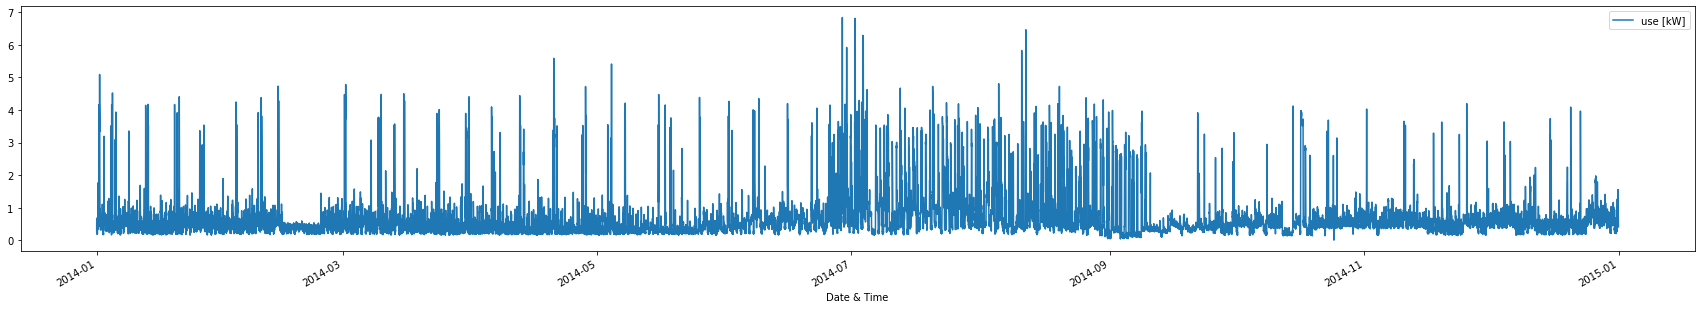

In [105]:
# Plot graphs for both the diagrams
energy_hourly_B.plot(kind='line', x='Date & Time', y='use [kW]', figsize=(30, 5))
plt.show()

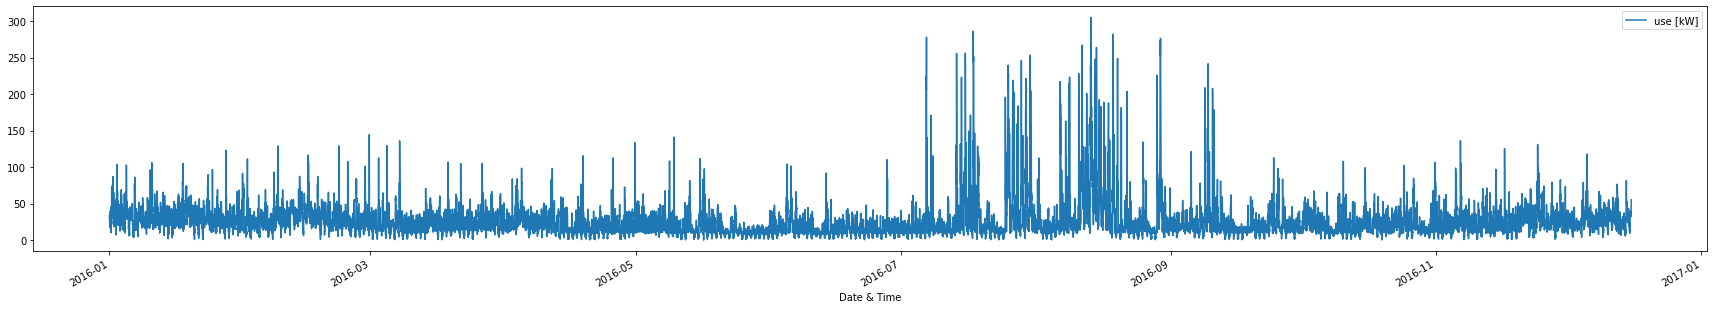

In [106]:
energy_hourly_C.plot(kind='line', x='Date & Time', y='use [kW]', figsize=(30, 5))
plt.show()

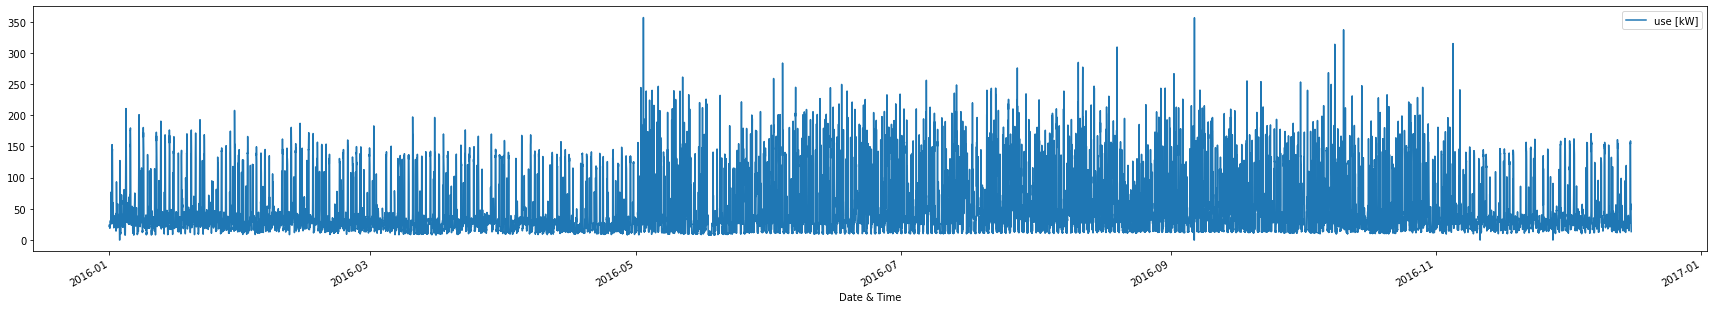

In [107]:
energy_hourly_F.plot(kind='line', x='Date & Time', y='use [kW]', figsize=(30, 5))
plt.show()

### Daily Plots

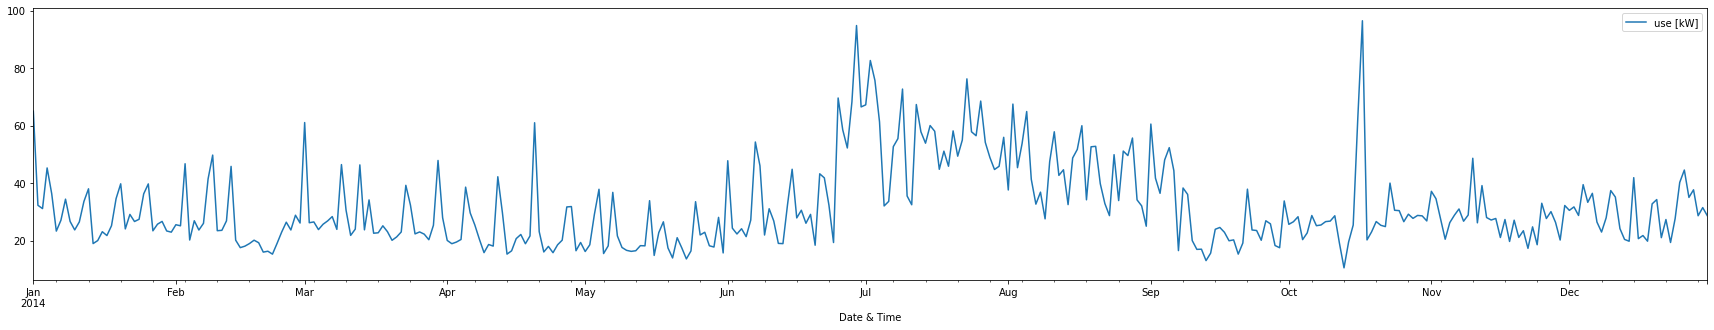

In [108]:
energy_daily_B.plot(kind='line', x='Date & Time', y='use [kW]', figsize=(30, 5))
plt.show()

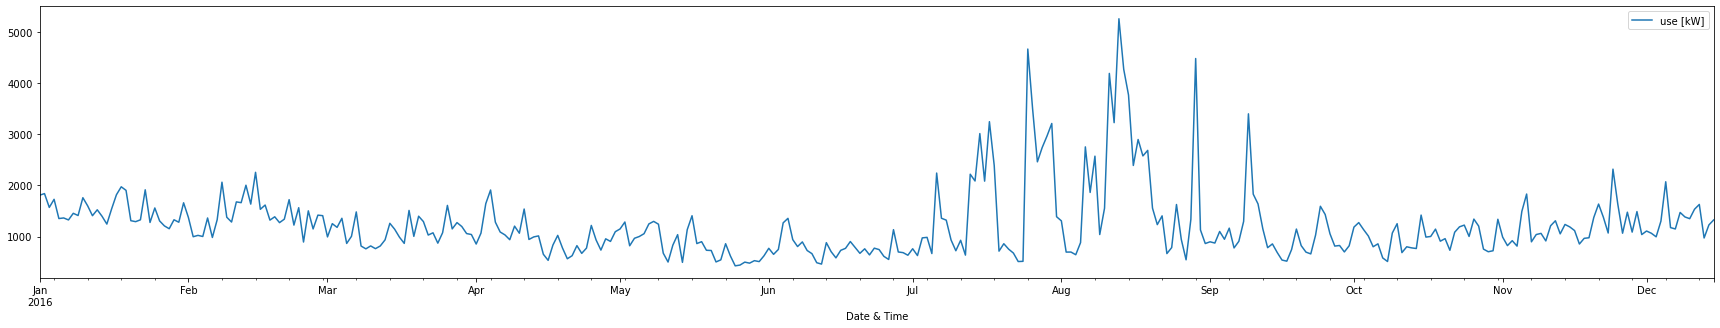

In [109]:
energy_daily_C.plot(kind='line', x='Date & Time', y='use [kW]', figsize=(30, 5))
plt.show()

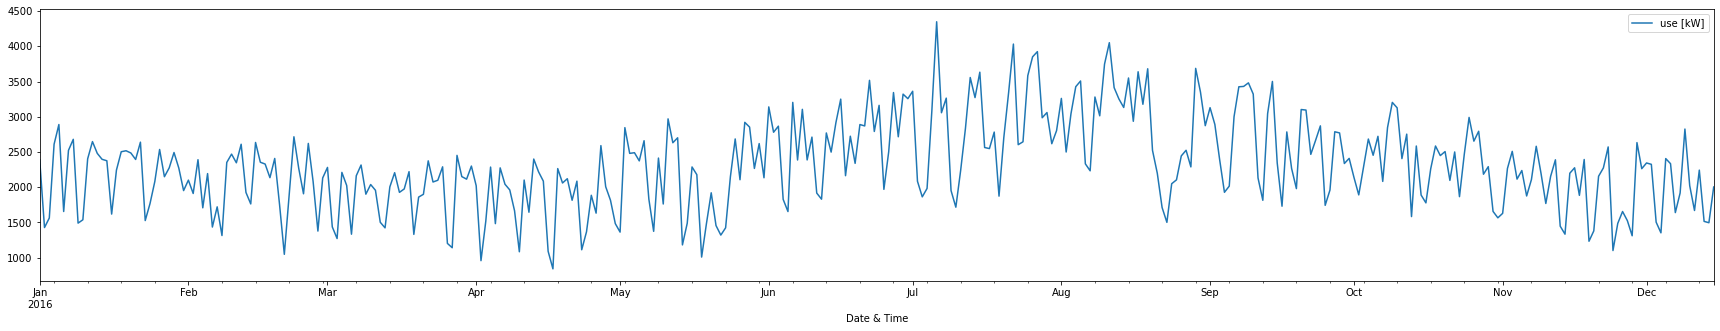

In [110]:
energy_daily_F.plot(kind='line', x='Date & Time', y='use [kW]', figsize=(30, 5))
plt.show()

From the above visualisations we can clearly see, as for House B & C , we observe significant spike during the late summer months. This might me due to excessive usage of cooling appliances.  House F on the other hand has high energy usage (High avg mean) all the year round. Probably House F would be a data of a bigger house or public place or any kind of hotels.

# Visualizing Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each numerical features present in the weather dataset. If we believe that any feature is correlated with another features, it might be  relevant for identifying the energy demand and the scatter matrix might show a correlation between that feature and another feature in the dataset.

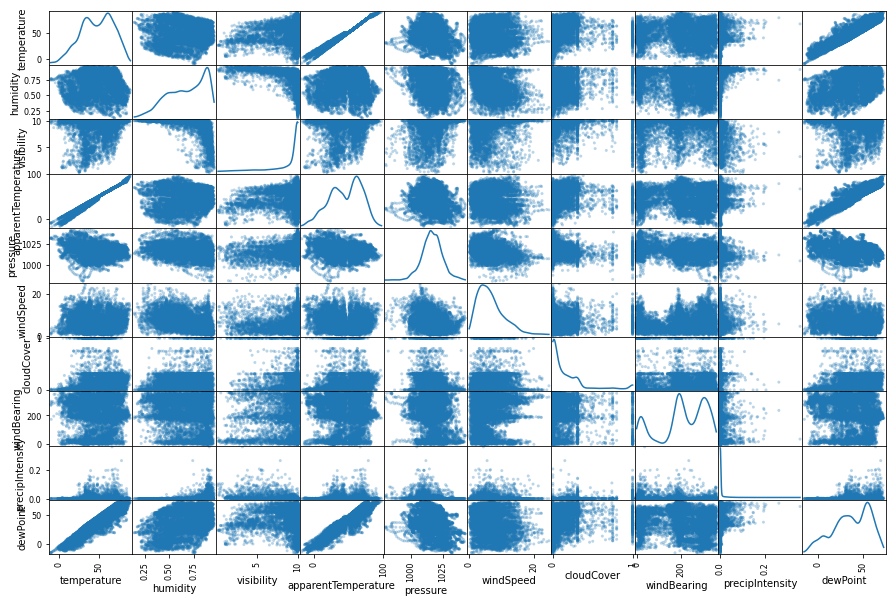

In [111]:
from pandas.plotting import scatter_matrix

data = weather_hourly_B[['temperature','humidity','visibility','apparentTemperature','pressure','windSpeed','cloudCover','windBearing','precipIntensity','dewPoint']]
scatter_matrix(data, alpha = 0.3, figsize = (15,10), diagonal = 'kde');

From the above diagram, from the data points in the scatter plot we can clearly see that **Temperature, Apparent Temperature and Dew point** are the most tightly clustered along an imaginary line, hence they have some positive correlation with each other. To further accentuate out observation, lets compute pairwise correlation of columns and plot it on heat map.

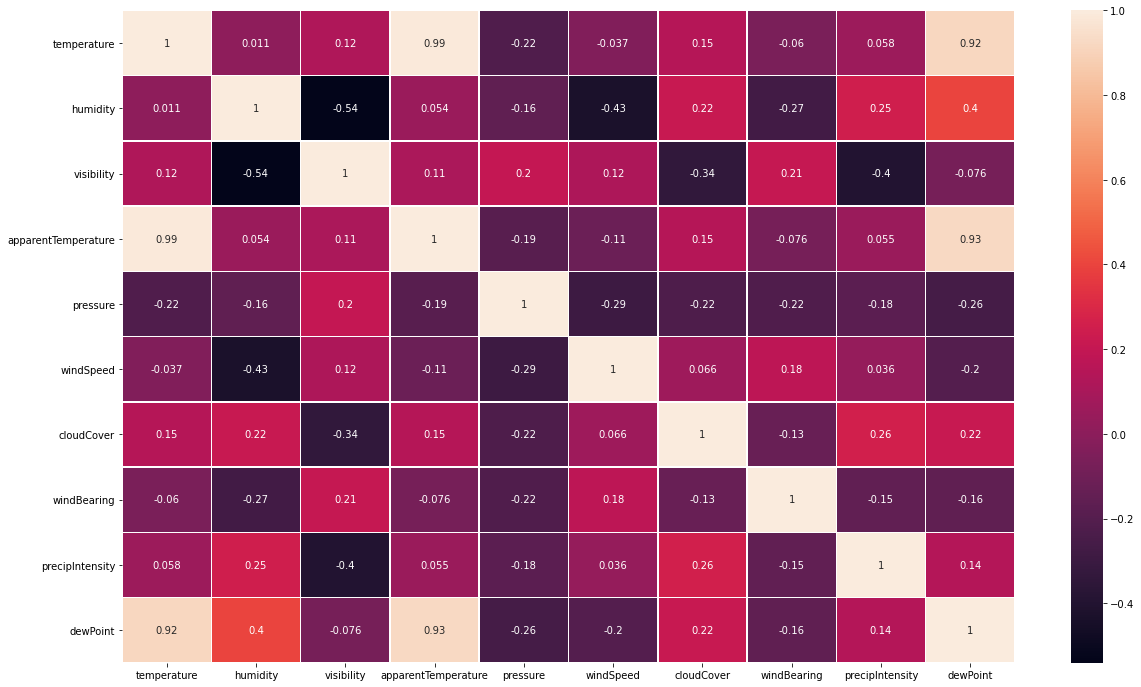

In [112]:
feature_corr = data.corr()
fig, ax = plt.subplots(figsize=(20,12))
sns.heatmap(feature_corr, annot=True, linewidths=.5)
plt.show()

The high correlation values of **Temperature**, **Apparent Temperature** and **Dew point** shows that they are closely amongst themselves. Hence as part of training & prediction, we can use amongst these to train and test models on the dataset. Since apparent temperature has a close synergy with Temperature feture, we shall use **temperature and dewPoint** to train our models.

In [113]:
linkedFeatures = ['temperature', 'dewPoint']

Now lets try and create models to predict the future electricity consumption of these houses on hourly and daily data points.

# Training & Prediction
Now that our data-preprocessing is done, we will use the datasets to train models, predict the energy usage and calculate the accuracy in terms of Mean Absolute Error.

We are using techniques like **Naive Method, Linear Regression, Decision tree Regression, Random Forest and ARIMA Model** to produce forecasts. For parameter tuning, I am using **Grid Search** Method to tune the hyperparameters.

As per the requirement specification, I am splitting the data set into two parts based on the date. I am using Jan to Nov data as the training set and Dec datapoints to test and calculate the MAE. 


## Naive Method Prediction
## Naive method is an estimating technique in which the last period's actual values are used to predict the future forecast, without adjusting them or attempting to establish causal factors. It is here used here as a baseline to compare forecasts generated by the better (sophisticated) techniques.

As one can see below, we are preparing test and train dataset based on split on date. For House B, we use training data from 1st Jan to 2014-12-01 00:00:00. For House C & F, We use training data from 1st Jan to "2016-11-15 00:00:00", since this would gave 30days data to test in both the cases.
Since we want to compare amongst similar data, we are storing the split points and using the same splits to test other algorithms so that we can compare them with Naive method.

In [114]:
# NAIVE Method Prediction
def naiveMethodPredictor(dataset, split):
    train_Y = dataset[:split]
    test_Y = dataset[split:]
    count = len(test_Y)
    predict_Y = pd.DataFrame(np.asarray(train_Y)[len(train_Y) - 1][0], index=np.arange(count), columns=['predicted'])
    mae = mean_absolute_error(test_Y, predict_Y)
    return mae

In [139]:
models.append("Naive Method")

splitHB = len(energy_hourly_B.loc[energy_hourly_B['Date & Time'] < '2014-11-01 00:00:00'])
maeVal = naiveMethodPredictor(energy_hourly_B[['use [kW]']], splitHB)
maeBHourly.append(maeVal)
print("The Mean Absolute Error of Naive method for Hourly points on House B is :", maeVal)

splitHC = len(energy_hourly_C.loc[energy_hourly_C['Date & Time'] < '2016-11-01 00:00:00'])
maeVal = naiveMethodPredictor(energy_hourly_C[['use [kW]']], splitHC)
maeCHourly.append(maeVal)
print("The Mean Absolute Error of Naive method for Hourly points on House C is :", maeVal)

splitHF = len(energy_hourly_F.loc[energy_hourly_F['Date & Time'] < '2016-11-01 00:00:00'])
maeVal = naiveMethodPredictor(energy_hourly_F[['use [kW]']], splitHF)
maeFHourly.append(maeVal)
print("The Mean Absolute Error of Naive method for Hourly points on House F is :", maeVal)

# splitDB = len(energy_daily_B.loc[energy_daily_B['Date & Time'] <= '2014-12-01 00:00:00'])
# maeVal = naiveMethodPredictor(energy_daily_B[['use [kW]']], splitDB)
# maeBDaily.append(maeVal)
# print("The Mean Absolute Error of Naive method for Daily points on House B is :", maeVal)

# splitDC = len(energy_daily_C.loc[energy_daily_C['Date & Time'] <= '2016-11-15 00:00:00'])
# maeVal = naiveMethodPredictor(energy_daily_C[['use [kW]']], splitDC)
# maeCDaily.append(maeVal)
# print("The Mean Absolute Error of Naive method for Daily points on House C is :", maeVal)

# splitDF = len(energy_daily_F.loc[energy_daily_F['Date & Time'] <= '2016-11-15 00:00:00'])
# maeVal = naiveMethodPredictor(energy_daily_F[['use [kW]']], splitDF)
# maeFDaily.append(maeVal)
# print("The Mean Absolute Error of Naive method for Daily points on House F is :", maeVal)


The Mean Absolute Error of Naive method for Hourly points on House B is : 0.23155540371174863
The Mean Absolute Error of Naive method for Hourly points on House C is : 12.554022175448308
The Mean Absolute Error of Naive method for Hourly points on House F is : 23.348081943687674


In [116]:
splitPoints=[]
splitPoints.append(splitHB)
splitPoints.append(splitHC)
splitPoints.append(splitHF)
splitPoints.append(splitDB)
splitPoints.append(splitDC)
splitPoints.append(splitDF)

In an attempt to compare apples to apples, we are memoizing the split points and use the same to test and train different models.

In [117]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 30), dpi=200, facecolor='w', edgecolor='k')
    
def plotvalues(x, y1, y2, house, model1, model2, interval):
    plt.title('Time Series plot at: ' + house + " " + interval)
    plt.xlabel('Date & Time')
    plt.ylabel('Use [kWh]')
    plt.plot(x, y1,'b', label=model1)
    plt.plot(x, y2,'r', label=model2)
    plt.legend(loc='upper left')
    plt.show()


<Figure size 2000x6000 with 0 Axes>

# Linear Regression
Linear regression attempts to model the relationship between two variables by fitting a linear equation to observed data. One variable is considered to be an explanatory variable, and the other is considered to be a dependent variable. We are using the the features which we obtained from feature distribution. I am using the split points I extracted above to prepare training and testing datasets.

For training features, I am using the temperature and dewpoint for training and predict energy usages based on it. Then I have plots of graphs for the actual energy usage values vs the predicted values.

### Normalising the features 
Since we will be using the features like Temperature and Dew Point, the values of these features are in different magnitude. For example for House B weather data, as seen above, (temperature has max value of 89 and min value of -10) and dew point varies from (-15 to 72). Hence we are normailising the features datatset to bring them into same order.

In [118]:
# Train Linear Regression model and predict

def LinearRegressionModel(features, target, split, house, interval):
    df = features[linkedFeatures].reset_index(drop=True)
    min_max_scaler = preprocessing.MinMaxScaler()
    scaled = min_max_scaler.fit_transform(df.values)
    scaled = pd.DataFrame(scaled, columns=df.columns, index=df.index)
    xtrain = scaled[:split].reset_index(drop=True)
    
    ytrain = target[:split][['use [kW]']].reset_index(drop=True)
    ytest = target[split:][['use [kW]']].reset_index(drop=True)
    xtest = scaled[split : (split + len(ytest))].reset_index(drop=True)
    linear_regressor = LinearRegression()
    model = linear_regressor.fit(xtrain, ytrain)
    ypredict = linear_regressor.predict(xtest)
    mae = mean_absolute_error(ytest, ypredict)
    plotvalues(features[split : (split + len(ytest))][["Date & Time"]], ytest, ypredict, house ,"Actual", "Predicted", interval)
    return mae



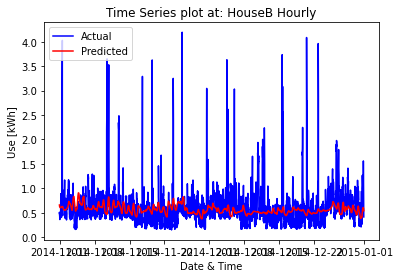

The Mean Absolute Error for Linear Regression for hourly points on House B is 0.23020036194686558


In [141]:
# models.append("Linear Regression")

maeVal = LinearRegressionModel(weatherb, energy_hourly_B, splitHB, "HouseB", "Hourly")
maeBHourly.append(maeVal)
print("The Mean Absolute Error for Linear Regression for hourly points on House B is", maeVal)


maeVal = LinearRegressionModel(weatherc, energy_hourly_C, splitHC, "HouseC", "Hourly")
maeCHourly.append(maeVal)
print("The Mean Absolute Error for Linear Regression for hourly points on House C is", maeVal)

maeVal = LinearRegressionModel(weatherF, energy_hourly_F, splitHF, "HouseF", "Hourly")
maeFHourly.append(maeVal)
print("The Mean Absolute Error for Linear Regression for hourly points on House F is", maeVal)






# maeVal = LinearRegressionModel(weather_daily_B, energy_daily_B, splitDB, "HouseB", "daily")
# maeBDaily.append(maeVal)
# print("The Mean Absolute Error for Linear Regression for daily points on House B is", maeVal)

# maeVal = LinearRegressionModel(weather_daily_C, energy_daily_C, splitDC, "HouseC", "daily")
# maeCDaily.append(maeVal)
# print("The Mean Absolute Error for Linear Regression for daily points on House C is", maeVal)

# maeVal = LinearRegressionModel(weather_daily_F, energy_daily_F, splitDF, "HouseF", "daily")
# maeFDaily.append(maeVal)
# print("The Mean Absolute Error for Linear Regression for daily points on House F is", maeVal)


# Decision Tree Regressor

A decision tree is a supervised machine learning model used to predict a target by learning decision rules from features. As the name suggests, we can think of this model as breaking down our data by making a decision based on asking a series of questions.
Initially we split the data based on the split points to prepare training and testing datasets and then we train models to get predicted values. We run it on default parameters in the first attemp. Following that , we try to improve the MAE by hyperparameter tuning using Grid Search as shown below.

In [ ]:
def DecisionTree(features, target, split):
    xtrain = features[:split][linkedFeatures].reset_index(drop=True)
    ytrain = target[:split][['use [kW]']].reset_index(drop=True)
    ytest = target[split:][['use [kW]']].reset_index(drop=True)
    xtest = features[split : (split + len(ytest))][linkedFeatures].reset_index(drop=True)
    regressor = DecisionTreeRegressor(random_state=0)
    model = regressor.fit(xtrain, ytrain.values.ravel())
    mae = mean_absolute_error(ytest, model.predict(xtest))
    return mae

### Hourly & Daily MAE for Houses B, C, & F

In [ ]:
models.append("Decision Tree (Without Grid Search)")

maeVal = DecisionTree(weather_hourly_B, energy_hourly_B, splitHB)
maeBHourly.append(maeVal)
print("The Mean Absolute Error for DecisionTree Model for hourly points on House B is", maeVal)

maeVal = DecisionTree(weather_hourly_C, energy_hourly_C, splitHC)
maeCHourly.append(maeVal)
print("The Mean Absolute Error for DecisionTree Model for hourly points on House C is", maeVal)

maeVal = DecisionTree(weather_hourly_F, energy_hourly_F, splitHF)
maeFHourly.append(maeVal)
print("The Mean Absolute Error for DecisionTree Model for hourly points on House F is", maeVal)

maeVal = DecisionTree(weather_daily_B, energy_daily_B, splitDB)
maeBDaily.append(maeVal)
print("The Mean Absolute Error for DecisionTree Model for daily points on House B is", maeVal)

maeVal = DecisionTree(weather_daily_C, energy_daily_C, splitDC)
maeCDaily.append(maeVal)
print("The Mean Absolute Error for DecisionTree Model for daily points on House C is", maeVal)

maeVal = DecisionTree(weather_daily_F, energy_daily_F, splitDF)
maeFDaily.append(maeVal)
print("The Mean Absolute Error for DecisionTree Model for daily points on House F is", maeVal)

# Grid Search | Parameter Tuning & Optimising Model Performance

Grid search is an algorithm with which we tune hyperparameters (example max_depth in our case) of our model. The input to grid search is possible values of hyperparamters and possible tuning metric.

The algo tries all possible commbinations of of hyperparameters in a grid and evaluates the performance of each combo with some cross validation set. The output is the hyperparameter combo which produces the best result.

The performance metric is required to assess the which is the best performing hyperparamters to be used in learning algorithm. The grid signifies the exhaustive nature of approach to try out all possible combinations of the hyperparameters.

We are using **R2 Score**, to quantify your model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions.

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen."""
    score = r2_score(y_true, y_predict)
    return score

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    regressor = DecisionTreeRegressor()
    params = dict(max_depth=[1,2,3,4,5,6,7,8,9,10])
    scoring_fnc = make_scorer(performance_metric)
    grid = GridSearchCV(regressor,params,scoring=scoring_fnc)
    grid = grid.fit(X, y)
    return grid.best_estimator_

def DecisionTreeModel(features, target, split, house):
    xtrain = features[:split][linkedFeatures].reset_index(drop=True)
    ytrain = target[:split][['use [kW]']].reset_index(drop=True)
    ytest = target[split:][['use [kW]']].reset_index(drop=True)
    xtest = features[split : (split + len(ytest))][linkedFeatures].reset_index(drop=True)
    model = fit_model(xtrain, ytrain)
    print("Parameter 'max_depth' is {} for the optimal model.".format(model.get_params()['max_depth']))
    ypredict = model.predict(xtest)
    plotvalues(features[split : (split + len(ytest))][["Date & Time"]], ytest, ypredict, house ,"Actual", "Predicted", "")
    mae = mean_absolute_error(ytest, ypredict)
    return mae

### Hourly and Daily datapoints

In [ ]:
models.append("Decision Tree (With Grid Search)")

maeVal = DecisionTreeModel(weather_hourly_B, energy_hourly_B, splitHB, "House B")
maeBHourly.append(maeVal)
print("The Mean Absolute Error for DecisionTree Model for hourly points on House B is", maeVal)

maeVal = DecisionTreeModel(weather_hourly_C, energy_hourly_C, splitHC, "House C")
maeCHourly.append(maeVal)
print("The Mean Absolute Error for DecisionTree Model for hourly points on House C is", maeVal)

maeVal = DecisionTreeModel(weather_hourly_F, energy_hourly_F, splitHF, "House F")
maeFHourly.append(maeVal)
print("The Mean Absolute Error for DecisionTree Model for hourly points on House F is", maeVal)

maeVal = DecisionTreeModel(weather_daily_B, energy_daily_B, splitDB, "House B")
maeBDaily.append(maeVal)
print("The Mean Absolute Error for DecisionTree Model for daily points on House B is", maeVal)

maeVal = DecisionTreeModel(weather_daily_C, energy_daily_C, splitDC, "House C")
maeCDaily.append(maeVal)
print("The Mean Absolute Error for DecisionTree Model for daily points on House C is", maeVal)

maeVal = DecisionTreeModel(weather_daily_F, energy_daily_F, splitDF, "House F")
maeFDaily.append(maeVal)
print("The Mean Absolute Error for DecisionTree Model for daily points on House F is", maeVal)

In [ ]:
decisionTree = pd.DataFrame({
    'Models': models,
    'House B (Hourly)': maeBHourly,
    'House C (Hourly)': maeCHourly,
    'House F (Hourly)': maeFHourly,
    'House B (Daily)': maeBDaily,
    'House C (Daily)': maeCDaily,
    'House F (Daily)': maeFDaily,
})
print("Differences between MAEs:")
display(decisionTree.loc[2:3])

Hence, its clear quantitatively, by how much **Grid Search parameter Tuning** improves the MAE of the predictions made by different datasets.

## Random Forest

Random Forest Regression is a supervised learning algorithm that uses ensemble learning method for regression. As we saw above the benefits of parameter tuning, we take multiple max depth values as input for tuning parameters. Then using the best estimator to calculate the MAE.

In [ ]:
def RandomForestModel(features, target, split):
    xtrain = features[:split][linkedFeatures].reset_index(drop=True)
    ytrain = target[:split][['use [kW]']].reset_index(drop=True)
    ytest = target[split:][['use [kW]']].reset_index(drop=True)
    xtest = features[split : (split + len(ytest))][linkedFeatures].reset_index(drop=True)
    
    randomforest = RandomForestRegressor(random_state=3)
    params = dict(max_depth=[1,2,3,4,5,6,7,8,9,10])
    scoring_fnc = make_scorer(performance_metric)
    grid = GridSearchCV(randomforest,params,scoring=scoring_fnc)
    grid = grid.fit(xtrain, ytrain.values.ravel())
    model =  grid.best_estimator_
    mae = mean_absolute_error(ytest, model.predict(xtest))
    return mae



In [ ]:
models.append("Random Forest")

maeVal = RandomForestModel(weather_hourly_B, energy_hourly_B, splitHB)
maeBHourly.append(maeVal)
print("The Mean Absolute Error for Random Forest for hourly points on House B is", maeVal)

maeVal = RandomForestModel(weather_hourly_C, energy_hourly_C, splitHC)
maeCHourly.append(maeVal)
print("The Mean Absolute Error for Random Forest for hourly points on House C is", maeVal)

maeVal = RandomForestModel(weather_hourly_F, energy_hourly_F, splitHF)
maeFHourly.append(maeVal)
print("The Mean Absolute Error for Random Forest for hourly points on House F is", maeVal)

maeVal = RandomForestModel(weather_daily_B, energy_daily_B, splitDB)
maeBDaily.append(maeVal)
print("The Mean Absolute Error for Random Forest for daily points on House B is", maeVal)

maeVal = RandomForestModel(weather_daily_C, energy_daily_C, splitDC)
maeCDaily.append(maeVal)
print("The Mean Absolute Error for Random Forest for daily points on House C is", maeVal)

maeVal = RandomForestModel(weather_daily_F, energy_daily_F, splitDF)
maeFDaily.append(maeVal)
print("The Mean Absolute Error for Random Forest for daily points on House F is", maeVal)

## ARIMA
ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

The parameters of the ARIMA model are defined as follows:

- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.

We will be iterating over the permissible values of p and d to get the best prediction in terms of minimum MAE.

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [ ]:
def testForParameters(train, test, split):
    ypredicted=[]
    optimalp =0
    optimald = 0
    leasterror = float("inf")
    for p in range(0,10):
        for d in range(0,2):
            newmodel = ARIMA(train, order=(p,d,0))
            model_fit = newmodel.fit()
            ypredicted = model_fit.predict(start=split, end=(split+len(test)-1)) 
            error = mean_absolute_error(test, ypredicted)
            if(error<leasterror):
                leasterror = error
                optimalp = p
                optimald = d
    return optimalp,optimald

def ArimaModel(ytrain, ytest, split, p, d):
    model = ARIMA(ytrain, order=(p,d,0))
    model = model.fit()
    ypredict = model.predict(start=split, end=(split+len(ytest)-1)) 
    print(model.summary())
    mae = mean_absolute_error(ytest, ypredict)
    plt.figure(figsize=(20,8))
    plt.plot(ytest)
    plt.plot(ypredict, color='red')
    plt.show()
    return mae
    

In [ ]:
models.append("ARIMA")
for i in range(6):
    target = energyData[i][['use [kW]']].values
    split = splitPoints[i]
    train = target[:split]
    test = target[split:]
    optimalp,optimald = testForParameters(train, test, split)
    print("Best P & D Values for ", tag[i]," are :", optimalp, "  ", optimald)
    mae = ArimaModel(train, test, split, optimalp, optimald)
    print ("The Mean Absolute Error for ARIMA Model for ", tag[i], "is :", mae)
    aggregate[i].append(mae)


# Final Results
Below are the aggregated results of MAE achieved by different models we tested above.

In [ ]:
results = pd.DataFrame({
    'Models': models,
    'House B (Hourly)': maeBHourly,
    'House C (Hourly)': maeCHourly,
    'House F (Hourly)': maeFHourly,
    'House B (Daily)': maeBDaily,
    'House C (Daily)': maeCDaily,
    'House F (Daily)': maeFDaily,
})
print("The final results on MAEs:")
display(results)

Hence we find different models performing differently for different house data sets. In particular we find the goodness of HyperParameter tuning in Decision Tree Regressor (comparing both rows 2 & 3). We have models which perform better than Naive Method viz Linear Regression performing better for all instances. Decision Tree with Grid Search performing quite better for House C Daily. Thus using different techniques and machine learning algorithms, we are able to predict energy consumption for different users with performances better than out baseline Naive model.  